# Import Libraries

In [ ]:
import pandas as pd
import pickle

# Import Data

In [119]:
df = pd.read_csv('all_leagues_data.csv', index_col=0)
df_match = pd.read_csv('Match_Info.csv', index_col=0)
df_team = pd.read_csv('Team_Info.csv', index_col=0)
elo_dict = pickle.load(open('elo_dict.pkl', 'rb'))
df_elo = pd.DataFrame.from_dict(elo_dict, orient='index')

# Data Cleaning and Exploratory Data Analysis

### General Info

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146498 entries, 0 to 146497
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Home_Team  146498 non-null  object
 1   Away_Team  146498 non-null  object
 2   Result     146498 non-null  object
 3   Link       146498 non-null  object
 4   Season     146498 non-null  int64 
 5   Round      146498 non-null  int64 
 6   League     146498 non-null  object
dtypes: int64(2), object(5)
memory usage: 8.9+ MB


Findings:
- No null values
- Dtypes as expected
- Only 7 features

Need to go deeper into each feature...

### Data Cleaning

In [67]:
# Check if all links appear to be valid
df['Link'].str.contains('https://www.besoccer.com/match/').value_counts()

# Visual inspection indicates that URL match the games in each row

True    146498
Name: Link, dtype: int64

In [68]:
# Check results are valid outcomes
print(df['Result'].str.len().value_counts())
print(df[df['Result'].str.len() != 3]['Result'])

# Drop 'Results' that do not add value to analysis or don't make sense (i.e. len(str(x)) !=3)
df.drop(df[df['Result'].str.len() != 3].index, inplace=True)

3    146487
4         5
9         4
6         2
Name: Result, dtype: int64
10615          10-2
33098        17 JAN
35163     1 (0-0) 1
42888          10-0
53431        18 MAR
57909          0-13
58699          10-0
60698     0 (0-0) 0
62800          10-0
140590    3 (3-2) 2
140592    0 (0-1) 1
Name: Result, dtype: object


In [69]:
# Check same No. home teams vs away teams in database
ht_count = df['Home_Team'].value_counts()
at_count = df['Away_Team'].value_counts()
diff_count = pd.concat([ht_count, at_count])
print(len(ht_count), len(at_count), len(diff_count))

538 545 1083


In [70]:
import difflib

# Create dictionary of team names to standardise
home_teams = ht_count.keys().tolist()
away_teams = at_count.keys().tolist()
all_teams = home_teams + away_teams
print(len(home_teams), len(away_teams), len(all_teams))

teams_dict = {}

for team in all_teams:
    teams_dict[team] = difflib.get_close_matches(team, away_teams)[0]

df['Home_Team_New'] = df['Home_Team'].apply(lambda x: teams_dict[x])
df['Away_Team_New'] = df['Away_Team'].apply(lambda x: teams_dict[x])

print((df['Home_Team'] == df['Home_Team_New']).value_counts())
print((df['Away_Team'] == df['Away_Team_New']).value_counts())


538 545 1083
True     146373
False       114
dtype: int64
True    146487
dtype: int64


In [71]:
# Convert results string to Home Team and Away Team scores as Integars
df['Home_Team_Score'] = df['Result'].apply(lambda x: int(x.split('-')[0]))
df['Away_Team_Score'] = df['Result'].apply(lambda x: int(x.split('-')[1]))
df.drop(columns=['Result'], inplace=True)
df

,Home_Team,Away_Team,Link,Season,Round,League,Home_Team_New,Away_Team_New,Home_Team_Score,Away_Team_Score
0,Millwall,Southend United,https://www.besoccer.com/match/millwall-fc/sou...,1995,1,championship,Millwall,Southend United,3,1
1,Portsmouth,Notts County,https://www.besoccer.com/match/portsmouth/nott...,1995,1,championship,Portsmouth,Notts County,2,1
2,Stoke City,Tranmere Rovers,https://www.besoccer.com/match/stoke-city/tran...,1995,1,championship,Stoke City,Tranmere Rovers,1,0
3,Barnsley,Derby County,https://www.besoccer.com/match/barnsley-fc/der...,1995,1,championship,Barnsley,Derby County,2,1
4,Middlesbrough,Burnley,https://www.besoccer.com/match/middlesbrough-f...,1995,1,championship,Middlesbrough,Burnley,2,0
...,...,...,...,...,...,...,...,...,...,...
146493,Frosinone,Pro Vercelli,https://www.besoccer.com/match/frosinone-calci...,2017,42,serie_b,Frosinone,Pro Vercelli,2,1
146494,Perugia,Salernitana,https://www.besoccer.com/match/perugia/salerni...,2017,42,serie_b,Perugia,Salernitana,3,2
146495,Vicenza,Spezia,https://www.besoccer.com/match/vicenza-calcio/...,2017,42,serie_b,Vicenza,Spezia,0,1
146496,Ascoli,Ternana Calcio,https://www.besoccer.com/match/ascoli/ternana-...,2017,42,serie_b,Ascoli,Ternana Calcio,1,2


In [72]:
df['Region'] = df['League']
values_to_update ={
    'Region': {
        'segunda_division': 'Spain',
        'primera_division': 'Spain',
        'serie_b': 'Italy',
        'serie_a': 'Italy',
        'premier_league': 'England',
        'championship': 'England',
        'ligue_1': 'France',
        'ligue_2': 'France',
        '2_liga': 'Germany',
        'bundesliga': 'Germany',
        'eredivisie': 'Netherlands',
        'eerste_divisie': 'Netherlands',
        'primeira_liga': 'Portugal',
        'segunda_liga': 'Portugal'        
        }
}

df = df.replace(values_to_update)
df

,Home_Team,Away_Team,Link,Season,Round,League,Home_Team_New,Away_Team_New,Home_Team_Score,Away_Team_Score,Region
0,Millwall,Southend United,https://www.besoccer.com/match/millwall-fc/sou...,1995,1,championship,Millwall,Southend United,3,1,England
1,Portsmouth,Notts County,https://www.besoccer.com/match/portsmouth/nott...,1995,1,championship,Portsmouth,Notts County,2,1,England
2,Stoke City,Tranmere Rovers,https://www.besoccer.com/match/stoke-city/tran...,1995,1,championship,Stoke City,Tranmere Rovers,1,0,England
3,Barnsley,Derby County,https://www.besoccer.com/match/barnsley-fc/der...,1995,1,championship,Barnsley,Derby County,2,1,England
4,Middlesbrough,Burnley,https://www.besoccer.com/match/middlesbrough-f...,1995,1,championship,Middlesbrough,Burnley,2,0,England
...,...,...,...,...,...,...,...,...,...,...,...
146493,Frosinone,Pro Vercelli,https://www.besoccer.com/match/frosinone-calci...,2017,42,serie_b,Frosinone,Pro Vercelli,2,1,Italy
146494,Perugia,Salernitana,https://www.besoccer.com/match/perugia/salerni...,2017,42,serie_b,Perugia,Salernitana,3,2,Italy
146495,Vicenza,Spezia,https://www.besoccer.com/match/vicenza-calcio/...,2017,42,serie_b,Vicenza,Spezia,0,1,Italy
146496,Ascoli,Ternana Calcio,https://www.besoccer.com/match/ascoli/ternana-...,2017,42,serie_b,Ascoli,Ternana Calcio,1,2,Italy


In [73]:
def result(x):
    if x['Home_Team_Score'] > x['Away_Team_Score']:
        return 'Win'

    elif x['Home_Team_Score'] == x['Away_Team_Score']:
        return 'Draw'
    else:
        return 'Loss'

df['Home_Team_Result'] = df.apply(lambda x: result(x), axis=1)
df

,Home_Team,Away_Team,Link,Season,Round,League,Home_Team_New,Away_Team_New,Home_Team_Score,Away_Team_Score,Region,Home_Team_Result
0,Millwall,Southend United,https://www.besoccer.com/match/millwall-fc/sou...,1995,1,championship,Millwall,Southend United,3,1,England,Win
1,Portsmouth,Notts County,https://www.besoccer.com/match/portsmouth/nott...,1995,1,championship,Portsmouth,Notts County,2,1,England,Win
2,Stoke City,Tranmere Rovers,https://www.besoccer.com/match/stoke-city/tran...,1995,1,championship,Stoke City,Tranmere Rovers,1,0,England,Win
3,Barnsley,Derby County,https://www.besoccer.com/match/barnsley-fc/der...,1995,1,championship,Barnsley,Derby County,2,1,England,Win
4,Middlesbrough,Burnley,https://www.besoccer.com/match/middlesbrough-f...,1995,1,championship,Middlesbrough,Burnley,2,0,England,Win
...,...,...,...,...,...,...,...,...,...,...,...,...
146493,Frosinone,Pro Vercelli,https://www.besoccer.com/match/frosinone-calci...,2017,42,serie_b,Frosinone,Pro Vercelli,2,1,Italy,Win
146494,Perugia,Salernitana,https://www.besoccer.com/match/perugia/salerni...,2017,42,serie_b,Perugia,Salernitana,3,2,Italy,Win
146495,Vicenza,Spezia,https://www.besoccer.com/match/vicenza-calcio/...,2017,42,serie_b,Vicenza,Spezia,0,1,Italy,Loss
146496,Ascoli,Ternana Calcio,https://www.besoccer.com/match/ascoli/ternana-...,2017,42,serie_b,Ascoli,Ternana Calcio,1,2,Italy,Loss


In [74]:
df = df.loc[:, ['Region', 'League', 'Season', 'Round', 'Home_Team_New', 'Home_Team_Score', 'Away_Team_Score', 'Away_Team_New', 'Home_Team_Result', 'Link']]
df.rename(columns={'Home_Team_New': 'Home_Team', 'Away_Team_New': 'Away_Team', 'Season': 'Year'}, inplace=True)
df


,Region,League,Year,Round,Home_Team,Home_Team_Score,Away_Team_Score,Away_Team,Home_Team_Result,Link
0,England,championship,1995,1,Millwall,3,1,Southend United,Win,https://www.besoccer.com/match/millwall-fc/sou...
1,England,championship,1995,1,Portsmouth,2,1,Notts County,Win,https://www.besoccer.com/match/portsmouth/nott...
2,England,championship,1995,1,Stoke City,1,0,Tranmere Rovers,Win,https://www.besoccer.com/match/stoke-city/tran...
3,England,championship,1995,1,Barnsley,2,1,Derby County,Win,https://www.besoccer.com/match/barnsley-fc/der...
4,England,championship,1995,1,Middlesbrough,2,0,Burnley,Win,https://www.besoccer.com/match/middlesbrough-f...
...,...,...,...,...,...,...,...,...,...,...
146493,Italy,serie_b,2017,42,Frosinone,2,1,Pro Vercelli,Win,https://www.besoccer.com/match/frosinone-calci...
146494,Italy,serie_b,2017,42,Perugia,3,2,Salernitana,Win,https://www.besoccer.com/match/perugia/salerni...
146495,Italy,serie_b,2017,42,Vicenza,0,1,Spezia,Loss,https://www.besoccer.com/match/vicenza-calcio/...
146496,Italy,serie_b,2017,42,Ascoli,1,2,Ternana Calcio,Loss,https://www.besoccer.com/match/ascoli/ternana-...


In [75]:
result_dummies = pd.get_dummies(df['Home_Team_Result'], prefix='Home_Team_Result')
result_dummies


,Home_Team_Result_Draw,Home_Team_Result_Loss,Home_Team_Result_Win
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
146493,0,0,1
146494,0,0,1
146495,0,1,0
146496,0,1,0


In [76]:
df = df.join(result_dummies)
df

,Region,League,Year,Round,Home_Team,Home_Team_Score,Away_Team_Score,Away_Team,Home_Team_Result,Link,Home_Team_Result_Draw,Home_Team_Result_Loss,Home_Team_Result_Win
0,England,championship,1995,1,Millwall,3,1,Southend United,Win,https://www.besoccer.com/match/millwall-fc/sou...,0,0,1
1,England,championship,1995,1,Portsmouth,2,1,Notts County,Win,https://www.besoccer.com/match/portsmouth/nott...,0,0,1
2,England,championship,1995,1,Stoke City,1,0,Tranmere Rovers,Win,https://www.besoccer.com/match/stoke-city/tran...,0,0,1
3,England,championship,1995,1,Barnsley,2,1,Derby County,Win,https://www.besoccer.com/match/barnsley-fc/der...,0,0,1
4,England,championship,1995,1,Middlesbrough,2,0,Burnley,Win,https://www.besoccer.com/match/middlesbrough-f...,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146493,Italy,serie_b,2017,42,Frosinone,2,1,Pro Vercelli,Win,https://www.besoccer.com/match/frosinone-calci...,0,0,1
146494,Italy,serie_b,2017,42,Perugia,3,2,Salernitana,Win,https://www.besoccer.com/match/perugia/salerni...,0,0,1
146495,Italy,serie_b,2017,42,Vicenza,0,1,Spezia,Loss,https://www.besoccer.com/match/vicenza-calcio/...,0,1,0
146496,Italy,serie_b,2017,42,Ascoli,1,2,Ternana Calcio,Loss,https://www.besoccer.com/match/ascoli/ternana-...,0,1,0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146487 entries, 0 to 146497
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Region                 146487 non-null  object
 1   League                 146487 non-null  object
 2   Year                   146487 non-null  int64 
 3   Round                  146487 non-null  int64 
 4   Home_Team              146487 non-null  object
 5   Home_Team_Score        146487 non-null  int64 
 6   Away_Team_Score        146487 non-null  int64 
 7   Away_Team              146487 non-null  object
 8   Home_Team_Result       146487 non-null  object
 9   Link                   146487 non-null  object
 10  Home_Team_Result_Draw  146487 non-null  uint8 
 11  Home_Team_Result_Loss  146487 non-null  uint8 
 12  Home_Team_Result_Win   146487 non-null  uint8 
dtypes: int64(4), object(6), uint8(3)
memory usage: 16.7+ MB


In [78]:
df.describe()

,Year,Round,Home_Team_Score,Away_Team_Score,Home_Team_Result_Draw,Home_Team_Result_Loss,Home_Team_Result_Win
count,146487.000000,146487.000000,146487.000000,146487.000000,146487.000000,146487.000000,146487.000000
mean,2005.518688,18.878078,1.500577,1.067433,0.282742,0.255797,0.461461
std,9.034836,11.088508,1.260164,1.081524,0.450334,0.436310,0.498514
min,1990.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1998.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2005.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,2013.000000,28.000000,2.000000,2.000000,1.000000,1.000000,1.000000
max,2021.000000,46.000000,9.000000,9.000000,1.000000,1.000000,1.000000


### Exploratory Data Analysis

/tmp/ipykernel_12480/155229678.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_win = df.groupby(by=['Region', 'Year'])['Home_Team_Result_Win', 'Home_Team_Result_Draw', 'Home_Team_Result_Loss'].sum().reset_index()


<AxesSubplot:title={'center':'No. Home Team Losses per Season'}, xlabel='Year', ylabel='Home_Team_Result_Loss'>

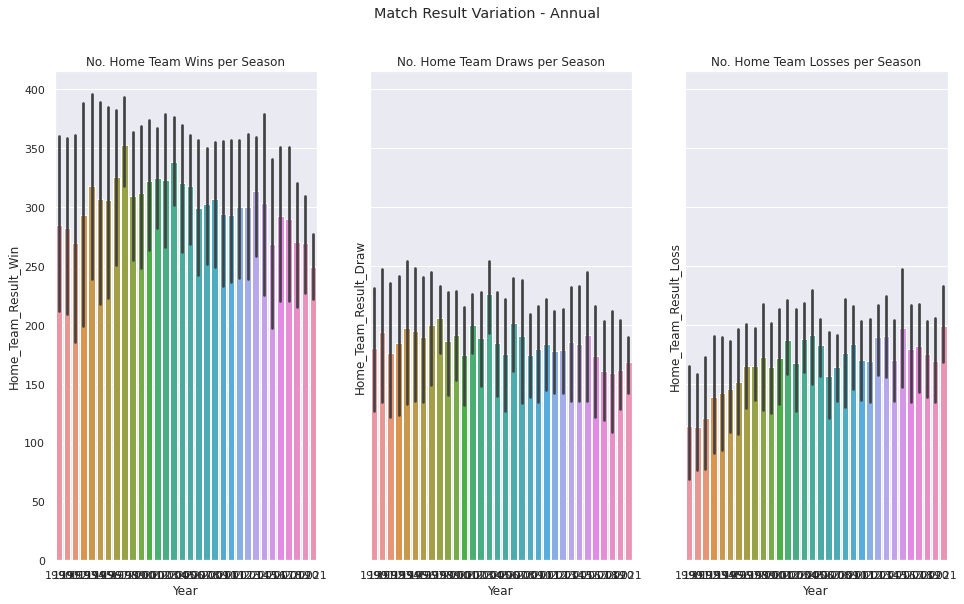

In [115]:
# Win percentage
df_win = df.groupby(by=['Region', 'Year'])['Home_Team_Result_Win', 'Home_Team_Result_Draw', 'Home_Team_Result_Loss'].sum().reset_index()

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(16, 9))
fig.suptitle('Match Result Variation - Annual')
ax[0].set_title('No. Home Team Wins per Season')
ax[1].set_title('No. Home Team Draws per Season')
ax[2].set_title('No. Home Team Losses per Season')
sns.barplot(ax=ax[0], data=df_win, x='Year', y='Home_Team_Result_Win')
sns.barplot(ax=ax[1], data=df_win, x='Year', y='Home_Team_Result_Draw')
sns.barplot(ax=ax[2], data=df_win, x='Year', y='Home_Team_Result_Loss')

/tmp/ipykernel_12480/3895487349.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['Region', 'Year'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Year'>

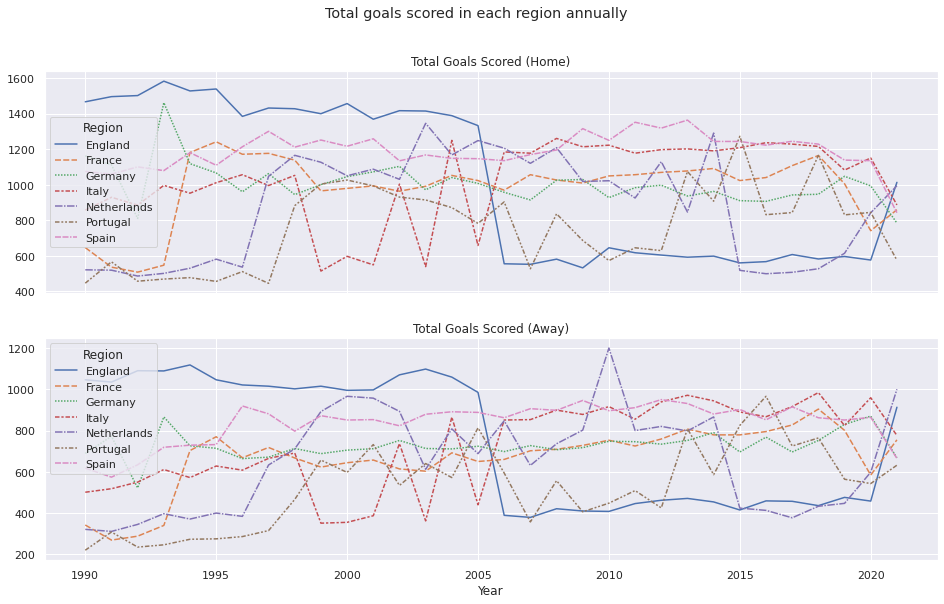

In [81]:
# How many goals were scored in each region?

df_goals = df.groupby(by=['Region', 'Year'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Year', columns='Region')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Year', columns='Region')

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
fig.suptitle('Total goals scored in each region annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

<AxesSubplot:xlabel='Year'>

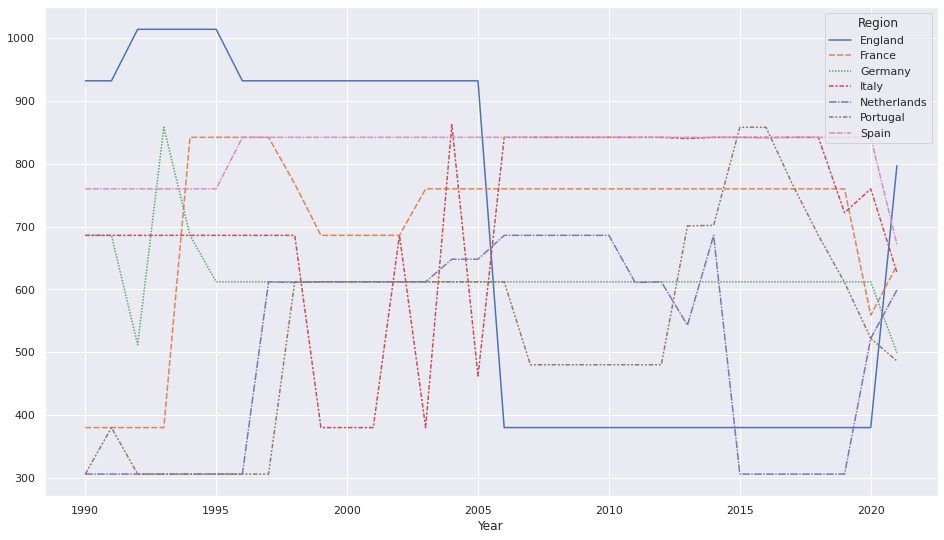

In [82]:
# How many games were played in each region?

df_games = df.groupby(by=['Region', 'Year'])['League'].count().to_frame().reset_index()
df_games = df_games.pivot_table(values='League', index='Year', columns='Region')

sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(data=df_games)

/tmp/ipykernel_12480/1334100787.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['Region', 'Year'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Year'>

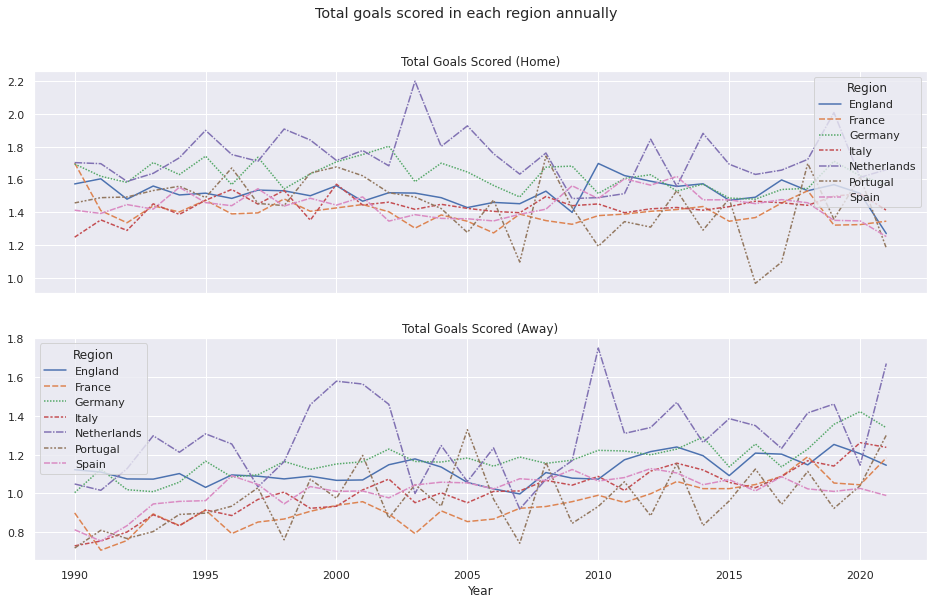

In [83]:
# How many goals are scored per game in each region?

df_goals = df.groupby(by=['Region', 'Year'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Year', columns='Region')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Year', columns='Region')

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 9))
fig.suptitle('Total goals scored in each region annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

/tmp/ipykernel_12480/4284934388.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['League', 'Year'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Year'>

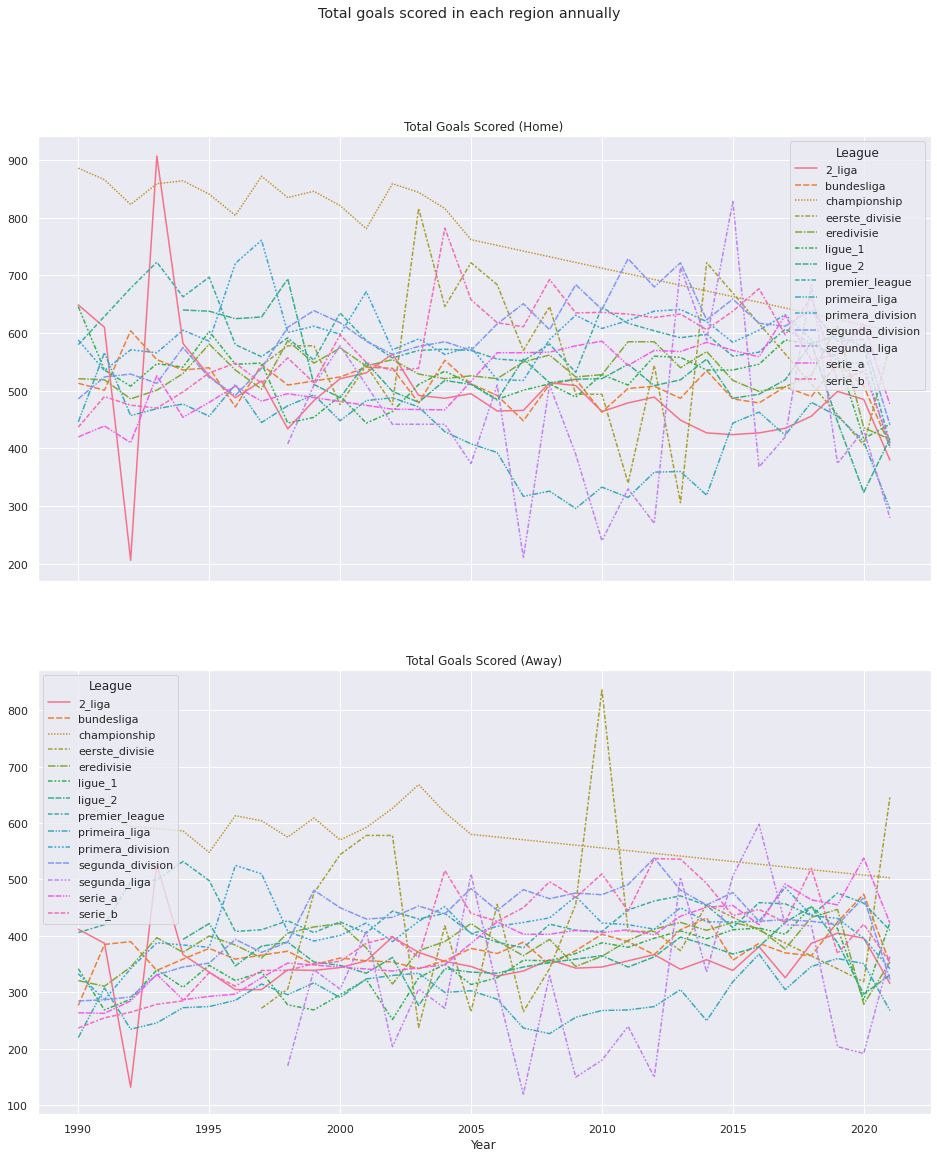

In [84]:
# How many goals were scored in each League?

df_goals = df.groupby(by=['League', 'Year'])['Home_Team_Score', 'Away_Team_Score'].sum().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Year', columns='League')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Year', columns='League')

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 18))
fig.suptitle('Total goals scored in each region annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

<AxesSubplot:xlabel='Year'>

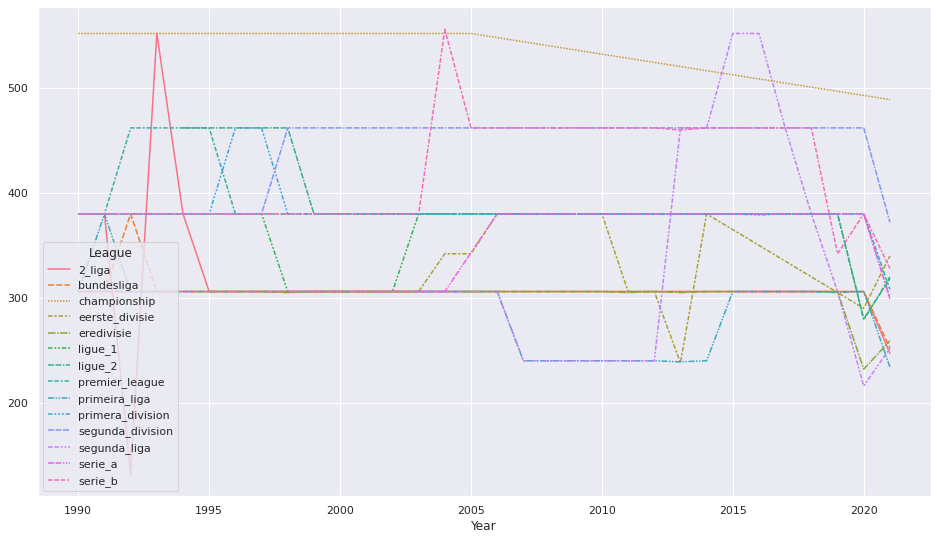

In [86]:
# How many games were played in each league?

df_games = df.groupby(by=['League', 'Year'])['Link'].count().to_frame().reset_index()
df_games = df_games.pivot_table(values='Link', index='Year', columns='League')

sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(data=df_games)

/tmp/ipykernel_12480/2760580341.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_goals = df.groupby(by=['League', 'Year'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()


<AxesSubplot:title={'center':'Total Goals Scored (Away)'}, xlabel='Year'>

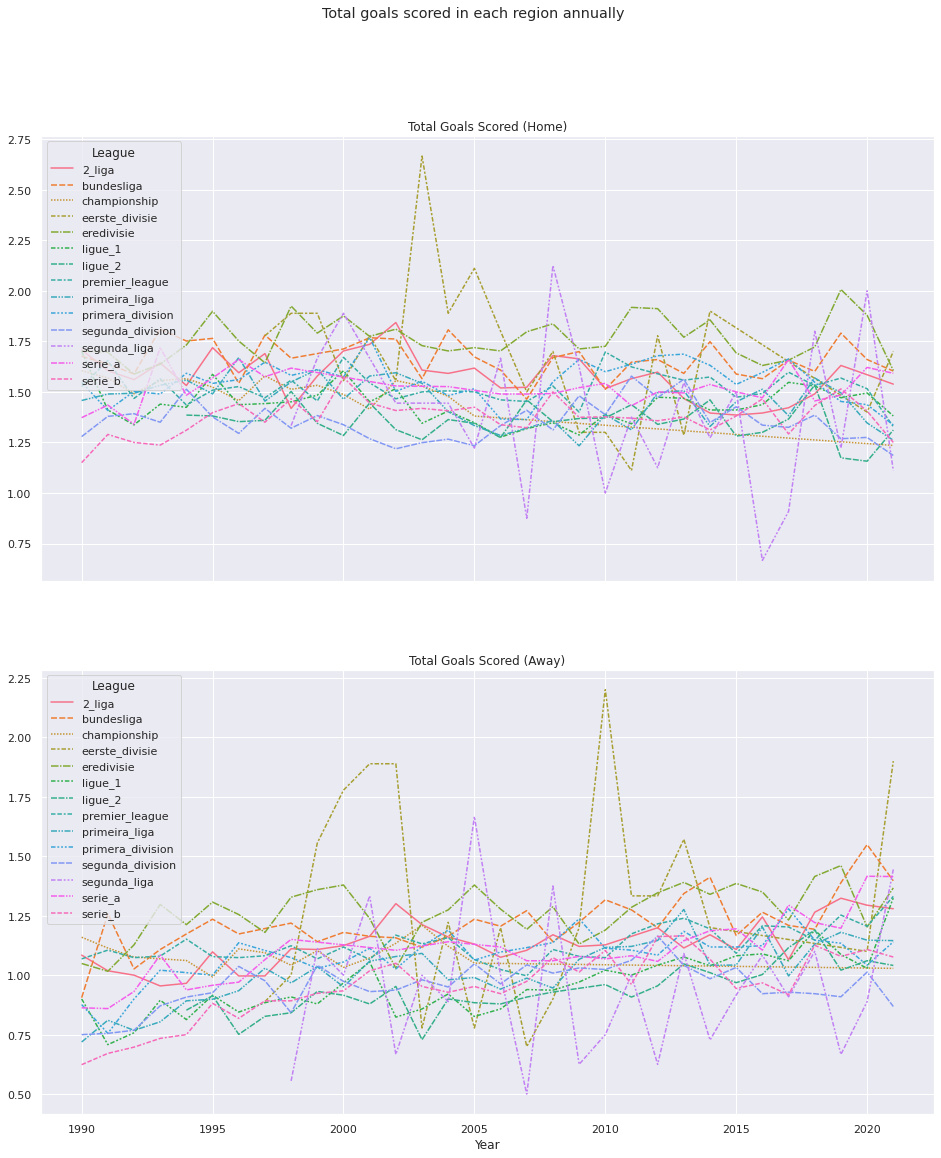

In [87]:
# How many goals are scored per game in each league?

df_goals = df.groupby(by=['League', 'Year'])['Home_Team_Score', 'Away_Team_Score'].mean().reset_index()
df_home_goals = df_goals.pivot_table(values='Home_Team_Score', index='Year', columns='League')
df_away_goals = df_goals.pivot_table(values='Away_Team_Score', index='Year', columns='League')

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 18))
fig.suptitle('Total goals scored in each region annually')
ax[0].set_title('Total Goals Scored (Home)')
ax[1].set_title('Total Goals Scored (Away)')
sns.lineplot(ax=ax[0], data=df_home_goals)
sns.lineplot(ax=ax[1], data=df_away_goals)

<AxesSubplot:xlabel='Year'>

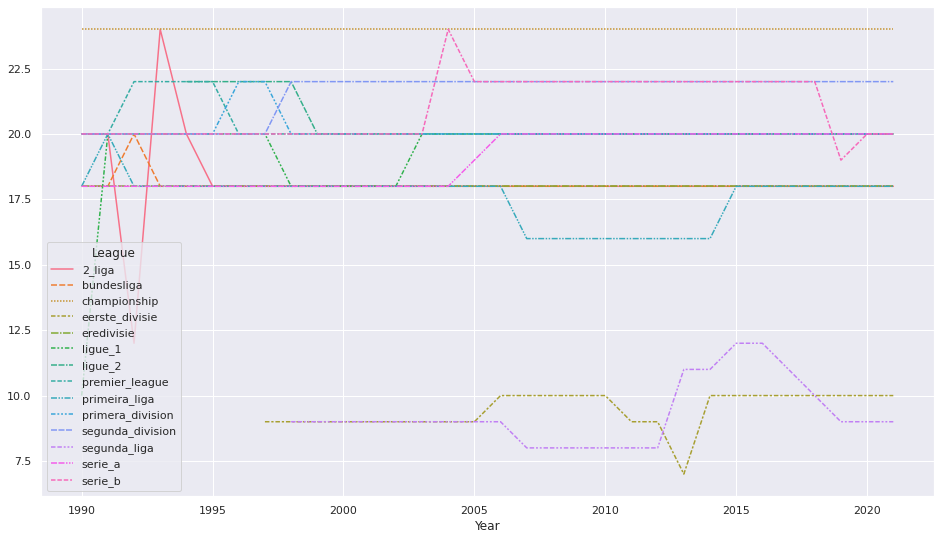

In [88]:
# How many teams played in each league?
teams_year_table = pd.pivot_table(df, values='Home_Team', index='Year', columns='League', aggfunc=lambda x: len(x.unique()))
teams_year_table


sns.set(rc={'figure.figsize':(16,9)})
sns.lineplot(data=teams_year_table)

In [89]:
# Which league has each team appeared in?
df_teams = df.groupby(by=['Home_Team', 'Year'])['League'].min()
df_teams = df_teams.to_frame().reset_index()
df_teams = df_teams.groupby(by=['Home_Team', 'League'])['Year'].count()
df_teams = df_teams.unstack(level=1)
df_teams.fillna(value=0, inplace=True)
df_teams


League,2_liga,bundesliga,championship,eerste_divisie,eredivisie,ligue_1,ligue_2,premier_league,primeira_liga,primera_division,segunda_division,segunda_liga,serie_a,serie_b
Home_Team,,,,,,,,,,,,,,
1. FC Lokomotive Leipzig,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1860 München,15.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC Arezzo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
AC Monza,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
ADO Den Haag,0.0,0.0,0.0,4.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Würzburger Kickers,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xerez,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,0.0,0.0,0.0
Zwickau,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# How many goals were scored by home and away teams in each league?

df_home_goals = df.groupby(by=['Region', 'League', 'Home_Team', 'Year'])['Home_Team_Score'].sum()
df_home_goals = df_home_goals.to_frame().reset_index()
df_home_goals

,Region,League,Home_Team,Year,Home_Team_Score
0,England,championship,AFC Bournemouth,1990,30
1,England,championship,AFC Bournemouth,2021,40
2,England,championship,Barnsley,1990,22
3,England,championship,Barnsley,1991,39
4,England,championship,Barnsley,1992,26
...,...,...,...,...,...
7469,Spain,segunda_division,Xerez,2011,32
7470,Spain,segunda_division,Xerez,2012,29
7471,Spain,segunda_division,Xerez,2013,14
7472,Spain,segunda_division,Écija Balompié,1996,22


In [91]:
df_away_goals = df.groupby(by=['Region', 'League', 'Away_Team', 'Year'])['Away_Team_Score'].sum()
df_away_goals = df_away_goals.to_frame().reset_index()
df_away_goals

,Region,League,Away_Team,Year,Away_Team_Score
0,England,championship,AFC Bournemouth,1990,27
1,England,championship,AFC Bournemouth,2021,26
2,England,championship,Barnsley,1990,27
3,England,championship,Barnsley,1991,24
4,England,championship,Barnsley,1992,19
...,...,...,...,...,...
7469,Spain,segunda_division,Xerez,2011,28
7470,Spain,segunda_division,Xerez,2012,21
7471,Spain,segunda_division,Xerez,2013,24
7472,Spain,segunda_division,Écija Balompié,1996,12


In [92]:
# Who is the most (and least) successful team in each league?
df_home = df.loc[:,['Home_Team', 'Home_Team_Score', 'Away_Team_Score', 'League', 'Region', 'Year', 'Round']]
df_home.rename(columns={'Home_Team': 'Team', 'Home_Team_Score': 'GS', 'Away_Team_Score': 'GC'}, inplace=True)
df_away = df.loc[:,['Away_Team', 'Away_Team_Score', 'Home_Team_Score', 'League', 'Region', 'Year', 'Round']]
df_away.rename(columns={'Away_Team': 'Team', 'Away_Team_Score': 'GS', 'Home_Team_Score': 'GC'}, inplace=True)
df_points = pd.concat([df_home, df_away]).reset_index(drop=True)

def win_func(x):
    if x['GS'] > x['GC']:
        return 3
    elif x['GS'] == x['GC']:
        return 1
    else:
        return 0

df_points['Result'] = df_points.apply(lambda row: win_func(row), axis=1)
df_points

,Team,GS,GC,League,Region,Year,Round,Result
0,Millwall,3,1,championship,England,1995,1,3
1,Portsmouth,2,1,championship,England,1995,1,3
2,Stoke City,1,0,championship,England,1995,1,3
3,Barnsley,2,1,championship,England,1995,1,3
4,Middlesbrough,2,0,championship,England,1995,1,3
...,...,...,...,...,...,...,...,...
292969,Pro Vercelli,1,2,serie_b,Italy,2017,42,0
292970,Salernitana,2,3,serie_b,Italy,2017,42,0
292971,Spezia,1,0,serie_b,Italy,2017,42,3
292972,Ternana Calcio,2,1,serie_b,Italy,2017,42,3


In [93]:
df_result = df_points.groupby(by=['Region', 'League', 'Team', 'Year'])['Result'].sum()
df_result

Region   League            Team             Year
England  championship      AFC Bournemouth  1990    48
                                            2021    71
                           Barnsley         1990    54
                                            1991    69
                                            1992    59
                                                    ..
Spain    segunda_division  Xerez            2011    60
                                            2012    50
                                            2013    30
                           Écija Balompié   1996    45
                                            1997    30
Name: Result, Length: 7891, dtype: int64

# Feature Engineering